In [1]:
import os
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import CenterCrop
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

import PIL

2022-12-22 07:47:03.479342: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
plt.rcParams["figure.figsize"] = (10, 5)

In [3]:
tf.__version__

'2.9.1'

# EDA

## Examine Image Sizes

In [4]:
image_dir = 'images/'
files = os.listdir(image_dir)
images = [f for f in files if re.search(r'.jpg$', f)]

sizes = []

for image in images:
    img = PIL.Image.open(f'{image_dir}/{image}')
    sizes.append(img.size)

In [5]:
sizes_df = pd.DataFrame({'img_size':sizes})
sizes_df.value_counts(ascending=False)

img_size   
(750, 1000)    6505
(1000, 750)     552
(562, 1000)     518
(450, 1000)     290
(753, 1000)     196
               ... 
(746, 690)        1
(625, 1000)       1
(619, 1000)       1
(612, 408)        1
(656, 468)        1
Length: 64, dtype: int64

The majority of the images of the images are 750x1000, but there's a long tail of differing sizes.

## Get Training Dataset

Note, `dataset_generator.ipynb` creates correct directory structure for the training images as specified in `test.csv`

In [9]:
img_size = (256, 256)

dataset = keras.preprocessing.image_dataset_from_directory(
    'images_by_class/train/',
    batch_size=None, 
    image_size=img_size
)

Found 5559 files belonging to 6 classes.


2022-12-22 07:49:57.823478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 07:49:57.899704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 07:49:57.900373: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-22 07:49:57.903964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

## Look at image data

In [10]:
for image, label in dataset.take(3):
    print(image.shape)  # (64, 200, 200, 3)
    print(image[0,0,])
    print(image.dtype)  # float32
    print(label.shape)  # (64,)
    print(label)
    print(label.dtype)  # int32

(256, 256, 3)
tf.Tensor([158.29657 145.40955 119.37109], shape=(3,), dtype=float32)
<dtype: 'float32'>
()
tf.Tensor(5, shape=(), dtype=int32)
<dtype: 'int32'>
(256, 256, 3)
tf.Tensor([79.33234  62.332336 42.332336], shape=(3,), dtype=float32)
<dtype: 'float32'>
()
tf.Tensor(5, shape=(), dtype=int32)
<dtype: 'int32'>
(256, 256, 3)
tf.Tensor([145.60217 136.60217 129.60217], shape=(3,), dtype=float32)
<dtype: 'float32'>
()
tf.Tensor(3, shape=(), dtype=int32)
<dtype: 'int32'>


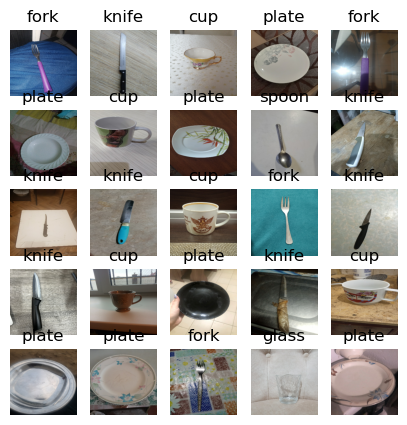

In [11]:
dataset_iterator = dataset.as_numpy_iterator()

plt.figure(figsize=(5, 5))
class_names = dataset.class_names

for i in range(25):
    image, label = next(dataset_iterator)
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image.astype("uint8"))
    plt.title(class_names[label])
    plt.axis("off")


### Ensure RGB values valid & examinne distribution of classes

In [12]:
dataset_iterator = dataset.as_numpy_iterator()

rgb_min = None
rgb_max = None
classes = []

for img, lbl in dataset_iterator:
    # append class
    classes.append(lbl)
    
    # get rgb values
    flat = img.flatten()

    flat_min = np.min(flat)
    flat_max = np.max(flat)

    if not rgb_min:
        rgb_min = flat_min
    else:
        rgb_min = np.min([flat_min, rgb_min])

    if not rgb_max:
        rgb_max = flat_max
    else:
        rgb_max = np.max([flat_max, rgb_max])

### RGB Values Valid

In [13]:
print([rgb_min, rgb_max])

[0.05706787, 255.0]


### Look at Distribution of classes

In [25]:
class_name_dict = dict(enumerate(class_names))

In [26]:
class_name_dict

{0: 'cup', 1: 'fork', 2: 'glass', 3: 'knife', 4: 'plate', 5: 'spoon'}

In [43]:
classes_df = pd.DataFrame({'class_id':classes})

class_counts = classes_df.value_counts(ascending=False).reset_index().rename(columns={0:'class_size'})

In [44]:
class_counts['class_name'] = class_counts.class_id.map(class_name_dict)
class_counts['perc'] = class_counts.class_size / np.sum(class_counts.class_size)

In [45]:
class_counts

,class_id,class_size,class_name,perc
0,4,1227,plate,0.220723
1,0,1135,cup,0.204173
2,5,989,spoon,0.177910
3,3,909,knife,0.163519
4,2,742,glass,0.133477
5,1,557,fork,0.100198


There's a relatively even distribution of classes - with plates occurring most frequently (\~22%) and forks least frequently (\~10%)

## Keras Tutorial Model

In [46]:
# https://keras.io/examples/vision/image_classification_from_scratch/
image_size = (256, 256)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "images_by_class/train/",
    label_mode='categorical',
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "images_by_class/train/",
    label_mode='categorical',
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 5559 files belonging to 6 classes.
Using 4448 files for training.
Found 5559 files belonging to 6 classes.
Using 1111 files for validation.


In [47]:
# following along with keras tutorial
# https://www.tensorflow.org/tutorials/images/classification

img_height = img_size[0]
img_width = img_size[1]
num_classes = len(class_names)

model = Sequential([
    keras.Input(shape=(img_height, img_width, 3)),
    
    layers.CenterCrop(height=img_height, width=img_width),
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dense(128, activation='relu'),
    layers.GlobalAveragePooling2D(),
    
    layers.Dense(num_classes, activation="softmax")
])

In [48]:
learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=['accuracy'])

In [49]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/10


2022-12-22 08:05:53.601225: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-12-22 08:05:55.595184: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 08:05:55.596110: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 08:05:55.596149: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-12-22 08:05:55.597169: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-12-22 08:05:55.597261: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


139/139 [==============================] - 19s 88ms/step - loss: 1.7683 - accuracy: 0.2140 - val_loss: 1.7616 - val_accuracy: 0.2115
Epoch 2/10
139/139 [==============================] - 12s 84ms/step - loss: 1.7640 - accuracy: 0.2230 - val_loss: 1.7606 - val_accuracy: 0.2115
Epoch 3/10
139/139 [==============================] - 12s 85ms/step - loss: 1.7636 - accuracy: 0.2230 - val_loss: 1.7609 - val_accuracy: 0.2115
Epoch 4/10
139/139 [==============================] - 12s 85ms/step - loss: 1.7636 - accuracy: 0.2230 - val_loss: 1.7609 - val_accuracy: 0.2115
Epoch 5/10
139/139 [==============================] - 12s 86ms/step - loss: 1.7628 - accuracy: 0.2230 - val_loss: 1.7604 - val_accuracy: 0.2115
Epoch 6/10
139/139 [==============================] - 12s 85ms/step - loss: 1.7620 - accuracy: 0.2230 - val_loss: 1.7602 - val_accuracy: 0.2115
Epoch 7/10
139/139 [==============================] - 12s 86ms/step - loss: 1.7618 - accuracy: 0.2230 - val_loss: 1.7602 - val_accuracy: 0.2115
Epo

In [50]:
def get_val_accuracy_delta(history):
    val_accuracy_start = history.history['val_accuracy'][0]
    val_accuracy_end = history.history['val_accuracy'][-1]
    
    return (val_accuracy_end - val_accuracy_start)

model_val_delta = get_val_accuracy_delta(history)

print(f'Change in validation accuracy: {model_val_delta:.3f}')

Change in validation accuracy: 0.000


Not a great model

### Transfer learning with Xception

We'll start with the Xception base model and add an additional dense layer on top of it

In [51]:
base_model = keras.applications.Xception(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(img_height, img_width, 3),
    include_top=False # Do not include the ImageNet classifier at the top.
)

base_model.trainable = False

inputs = keras.Input(shape=(img_height, img_width, 3))

x = tf.cast(inputs, tf.float32)
x = keras.applications.xception.preprocess_input(x)
x = base_model(inputs, training=False)
x = layers.MaxPooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)

model_x = keras.Model(inputs, outputs)

learning_rate = 0.01
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss = keras.losses.CategoricalCrossentropy()

model_x.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=['accuracy']
)

In [52]:
epochs = 10

history_x = model_x.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs
)

Epoch 1/10
139/139 [==============================] - 33s 209ms/step - loss: 24.7370 - accuracy: 0.2089 - val_loss: 1.7635 - val_accuracy: 0.2115
Epoch 2/10
139/139 [==============================] - 28s 200ms/step - loss: 1.7606 - accuracy: 0.2277 - val_loss: 1.7560 - val_accuracy: 0.2178
Epoch 3/10
139/139 [==============================] - 29s 203ms/step - loss: 1.7384 - accuracy: 0.2358 - val_loss: 1.7179 - val_accuracy: 0.2187
Epoch 4/10
139/139 [==============================] - 29s 204ms/step - loss: 1.6953 - accuracy: 0.2552 - val_loss: 1.6967 - val_accuracy: 0.2556
Epoch 5/10
139/139 [==============================] - 29s 206ms/step - loss: 1.6669 - accuracy: 0.2696 - val_loss: 1.6967 - val_accuracy: 0.2637
Epoch 6/10
139/139 [==============================] - 29s 208ms/step - loss: 1.6427 - accuracy: 0.2943 - val_loss: 1.6727 - val_accuracy: 0.2898
Epoch 7/10
139/139 [==============================] - 30s 209ms/step - loss: 1.6241 - accuracy: 0.3125 - val_loss: 1.6703 - val_a

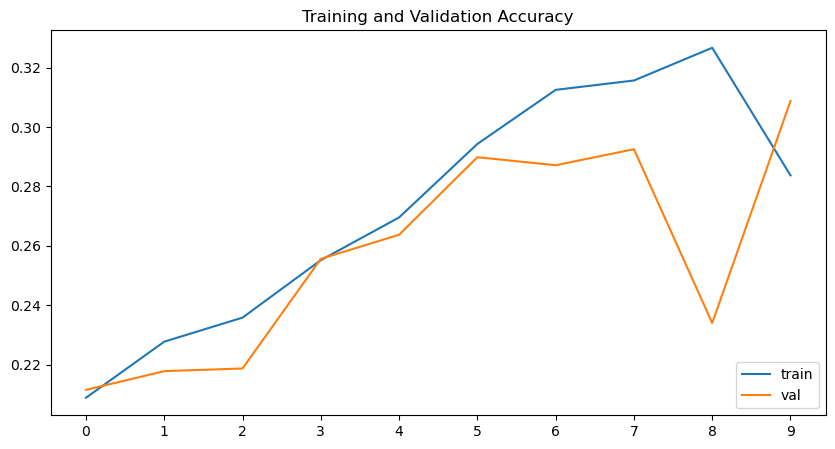

In [53]:
acc = history_x.history['accuracy']
val_acc = history_x.history['val_accuracy']

plt.plot(acc, label='train')
plt.plot(val_acc, label='val')
plt.xticks(np.arange(epochs))
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.show()

Much improvement here, but generally looks like we're overfitting as training accuracy continues to rise as validation accuracy flattens out. We'll continue on to explore a better learning rate.

### Adjust the learning rate

In [54]:
def make_model(learning_rate=0.01):
    
    base_model = keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(img_height, img_width, 3),
        include_top=False # Do not include the ImageNet classifier at the top.
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(img_height, img_width, 3))

    x = tf.cast(inputs, tf.float32)
    x = keras.applications.xception.preprocess_input(x)
    x = base_model(inputs, training=False)
    x = layers.MaxPooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)

    learning_rate = learning_rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    loss = keras.losses.CategoricalCrossentropy()

    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=['accuracy']
    )
    
    return model

In [55]:
scores = {}
epochs = 10

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = make_model(learning_rate=lr)
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        batch_size=32,
        epochs=epochs
    )
    scores[lr] = history.history

    print()
    print()

0.0001
Epoch 1/10
139/139 [==============================] - 31s 203ms/step - loss: 8.1002 - accuracy: 0.2842 - val_loss: 4.9318 - val_accuracy: 0.3177
Epoch 2/10
139/139 [==============================] - 28s 201ms/step - loss: 4.1327 - accuracy: 0.3624 - val_loss: 4.3680 - val_accuracy: 0.3528
Epoch 3/10
139/139 [==============================] - 29s 203ms/step - loss: 3.2408 - accuracy: 0.4083 - val_loss: 3.5413 - val_accuracy: 0.3393
Epoch 4/10
139/139 [==============================] - 29s 204ms/step - loss: 2.7984 - accuracy: 0.4332 - val_loss: 3.3807 - val_accuracy: 0.3825
Epoch 5/10
139/139 [==============================] - 29s 206ms/step - loss: 2.4159 - accuracy: 0.4631 - val_loss: 3.1625 - val_accuracy: 0.3582
Epoch 6/10
139/139 [==============================] - 29s 207ms/step - loss: 2.2400 - accuracy: 0.4766 - val_loss: 2.9867 - val_accuracy: 0.4203
Epoch 7/10
139/139 [==============================] - 29s 209ms/step - loss: 1.9425 - accuracy: 0.5178 - val_loss: 2.7447 -

Text(0.5, 1.0, 'Validation Accuracy by Learning Rate')

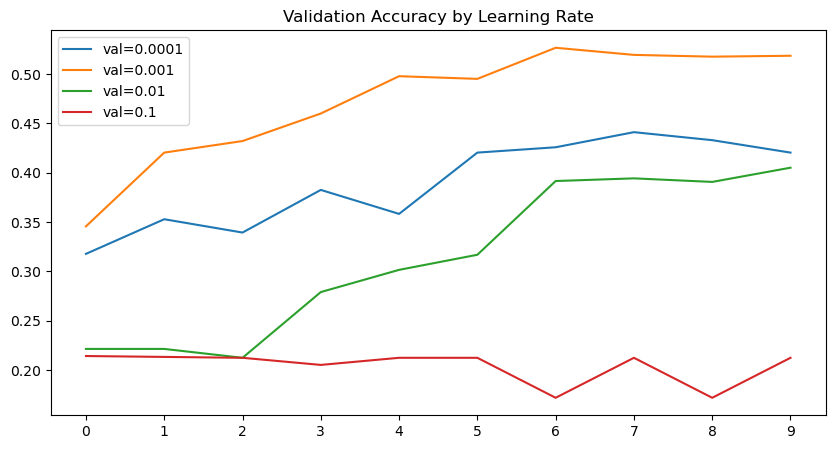

In [56]:
for lr, hist in scores.items():
    #plt.plot(hist['accuracy'], label=('train=%s' % lr))
    plt.plot(hist['val_accuracy'], label=('val=%s' % lr))

plt.xticks(np.arange(10))
plt.legend()
plt.title('Validation Accuracy by Learning Rate')

Pretty clearly `0.001` is our best learning rate, it's encouraging that performance continued to rise with epochs.

Text(0.5, 1.0, 'Learning rate:0.001, val & train accuracy')

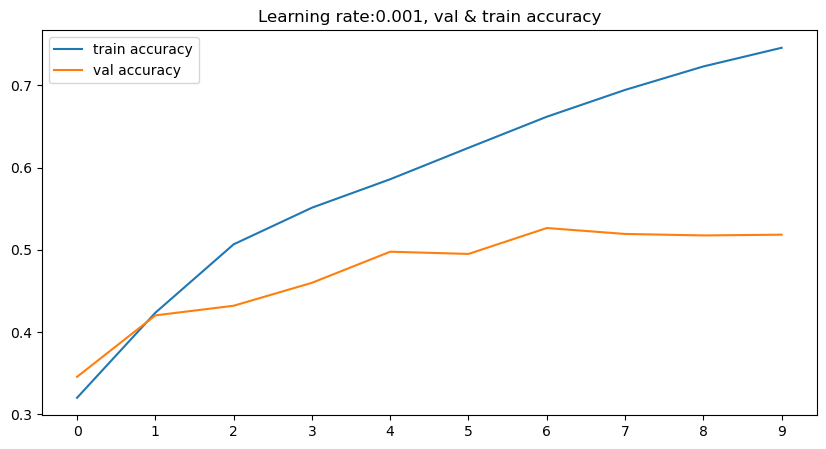

In [57]:
lr = 0.001
plt.plot(scores[lr]['accuracy'], label='train accuracy')
plt.plot(scores[lr]['val_accuracy'], label='val accuracy')

plt.xticks(np.arange(10))
plt.legend()
plt.title(f'Learning rate:{lr}, val & train accuracy')

It looks like we're at risk of overfitting. We could benefit by: 
* additional layers
* data-augmentation
* dropout
* transfer learning with a different base model
* fine-tuning the base model